Laden der notwendigen Bibliotheken

In [21]:
import os
import sys
import matplotlib.pyplot as plt
from matplotlib.image import AxesImage, NonUniformImage
import numpy as np
import math
import cv2
from PIL import Image
from astropy.io import fits
from pathlib import Path
from scipy.signal import find_peaks

In [ ]:
WINDOW = 512
IMAGE_SIZE = 32
current_path = Path('.')
TEST_DATA_PATH = current_path / '..' /'test' / 'images'
INTENSITY_SCALE = 1024

Definition des Kalibrierspektrums

In [23]:
homepath = Path('.')
fits_path = homepath / '..' / 'data' / 'NEON'
fits_name = 'Light_NEON_10sec_Bin1_22.1C_gain0_2025-06-04_211202_frame0001.fit'
fits_file = fits_path / fits_name


Laden der FITS-Datei

In [24]:
with fits.open(str(fits_file)) as hdul:
    hdul.info()
    data = hdul[0].data

Filename: ../data/NEON/Light_NEON_10sec_Bin1_22.1C_gain0_2025-06-04_211202_frame0001.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      40   (4944, 3284)   int16 (rescales to uint16)   


Anzeige der FITS Datei

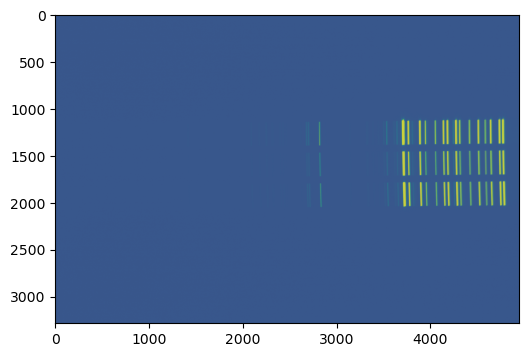

In [25]:
fig, axes = plt.subplots()
plt.imshow(data,vmin=0,vmax=1000)
plt.show()

Auswahl eines Schnitts bei y = 1500 entlang der Dispersionsachse

In [26]:
trace = data[1500,:]
trace_n = trace/max(trace)

Anzeige des Schnitts

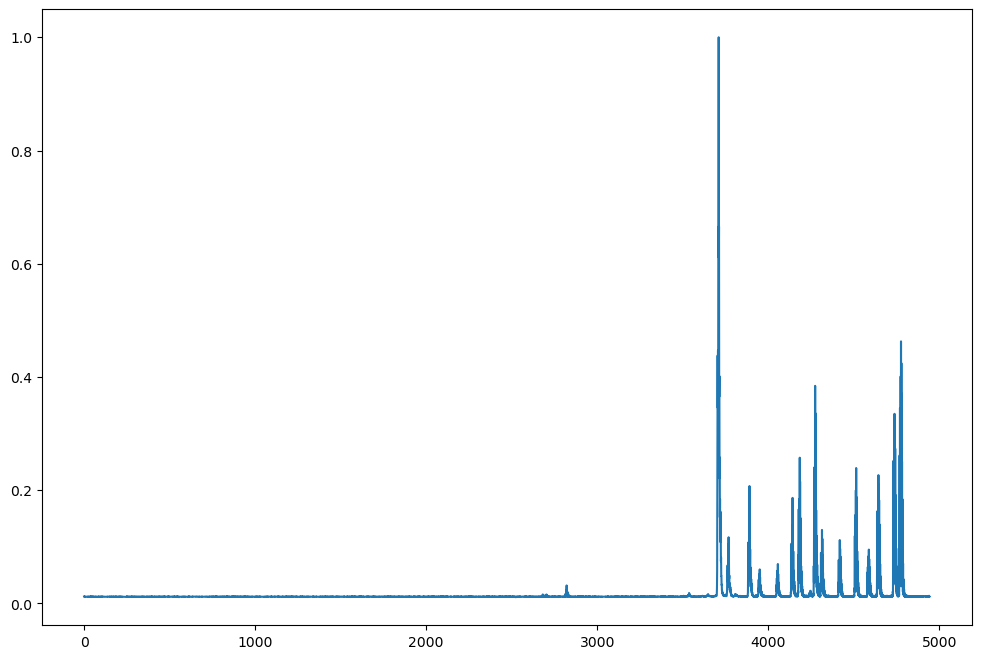

In [27]:
plt.rcParams['figure.figsize'] = (12,8)
fig, axes = plt.subplots()
plt.plot(trace_n)
plt.show()

Bestimmung der Linienpositionen mit scipy.find_peaks() - es werden Linienspitzen gesucht mit einer minimalen Intensität von 0.05 und einer Distanz zur nächsten Linienspitze von 15 (Pixel)) - Die Wahl der Parameter ist so zu wählen, dass möglichst nur die Linien gefunden werden, die auch im Referenzspektrum gekennzeichnet sind.

In [28]:
peak_positions = find_peaks(trace_n,0.05, distance=15)
print(peak_positions[0])
print(peak_positions[1]['peak_heights'])

[3710 3768 3890 3950 4056 4142 4184 4274 4314 4418 4514 4588 4644 4738
 4776]
[1.         0.11697045 0.20739692 0.06016634 0.06972217 0.18651566
 0.25747655 0.38435675 0.12988852 0.11201557 0.23924969 0.09520439
 0.22668554 0.33498496 0.46292692]


Manuelle Liste der Referenzlinien zu den gefundenen Peaks - falls Nan: keine Zuordnung. Angabe in nm hier

Plot der gefundenen Linien

3710,  1.00 
3768,  0.12 
3890,  0.21 
3950,  0.06 
4056,  0.07 
4142,  0.19 
4184,  0.26 
4274,  0.38 
4314,  0.13 
4418,  0.11 
4514,  0.24 
4588,  0.10 
4644,  0.23 
4738,  0.33 
4776,  0.46 


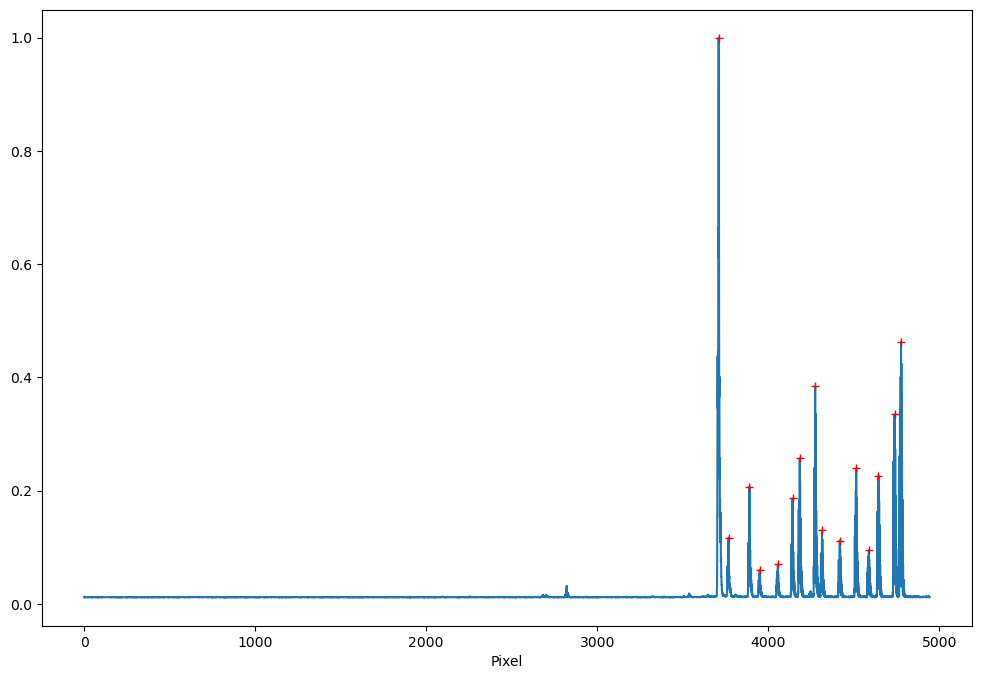

In [29]:
plt.rcParams['figure.figsize'] = (12,8)
fig, axes = plt.subplots()
plt.plot(trace_n)
for pos,val in zip(peak_positions[0], peak_positions[1]['peak_heights']):
    print(f'{pos}, {val:5.2f} ')
    plt.plot(pos, val,'+',color='red')
plt.xlabel('Pixel')
plt.show()

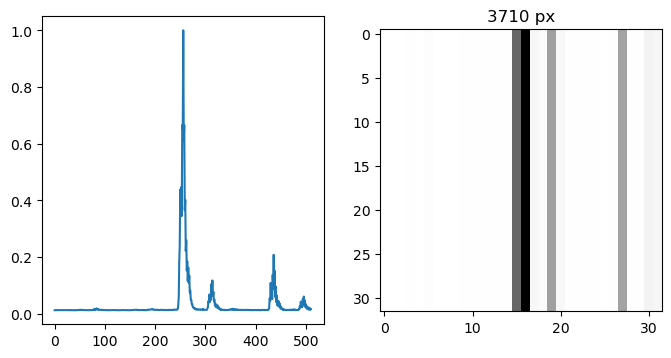

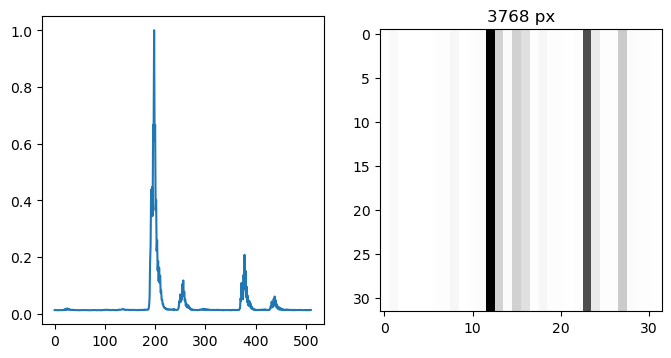

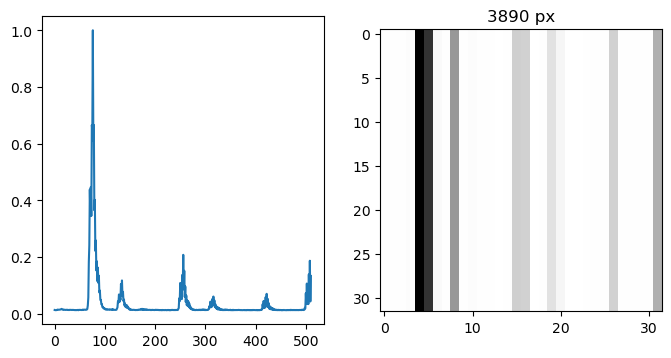

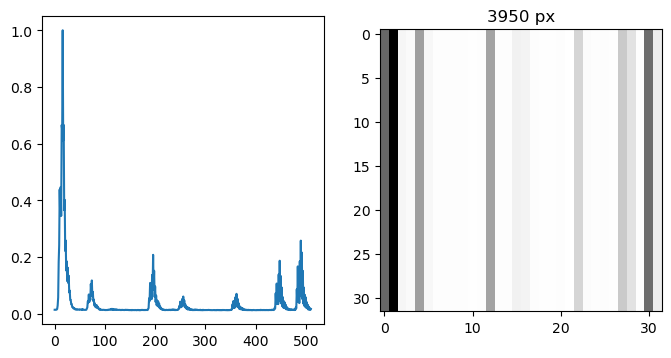

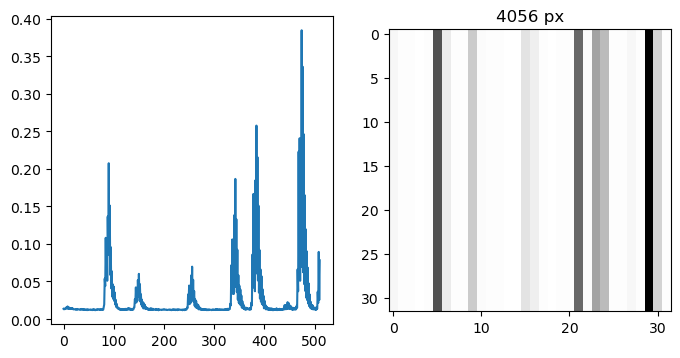

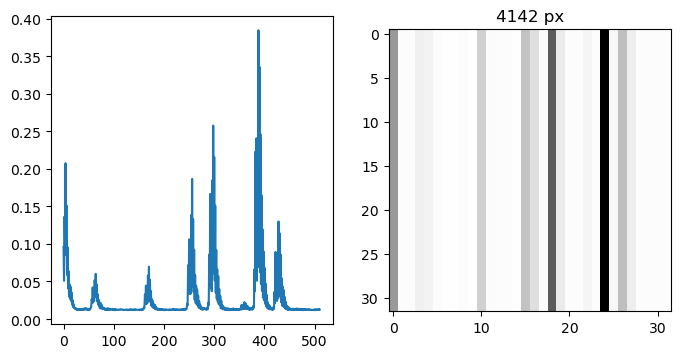

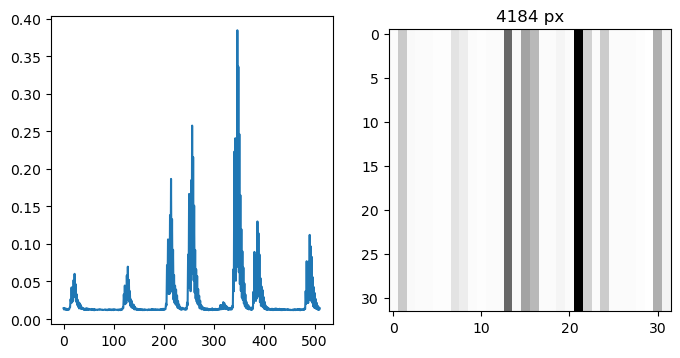

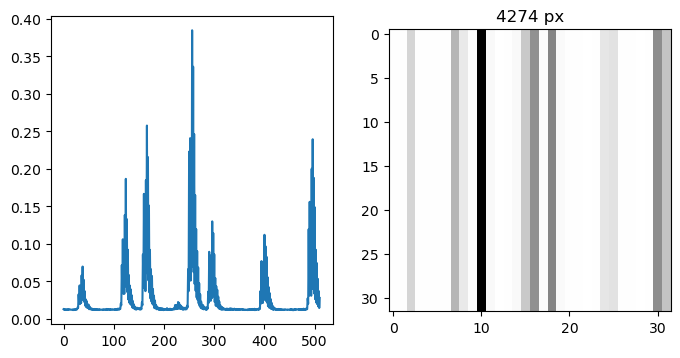

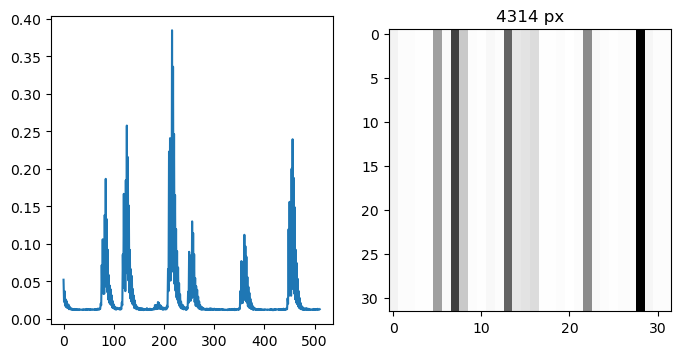

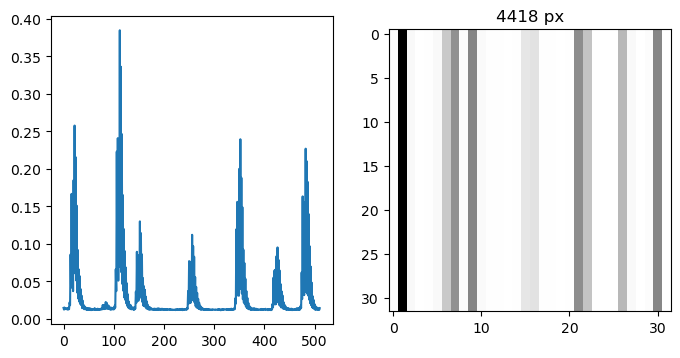

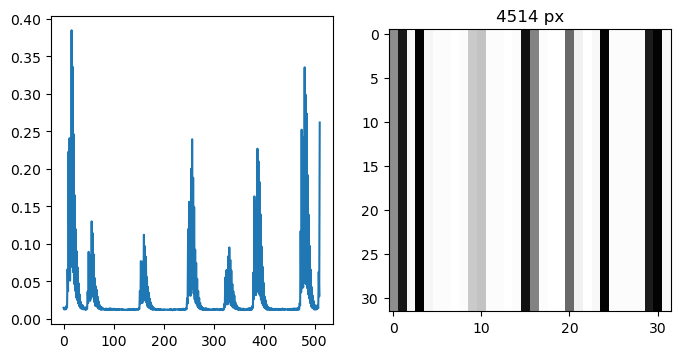

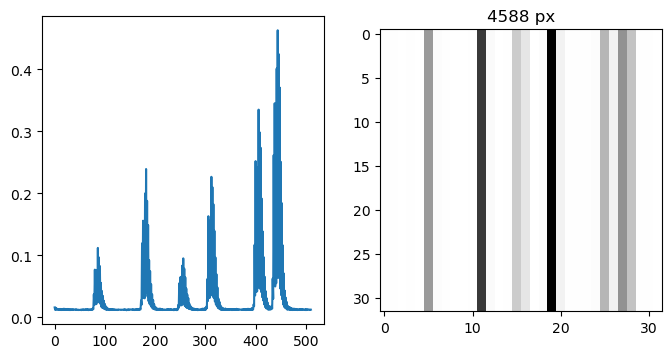

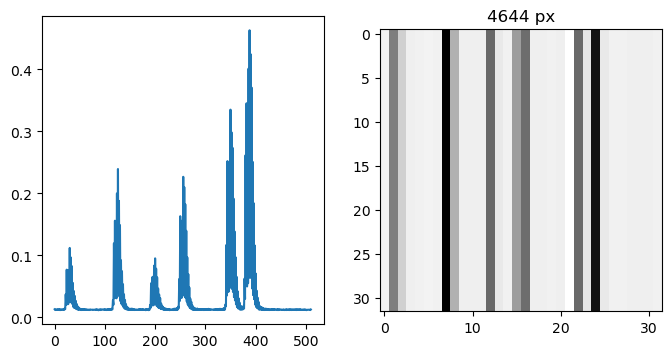

In [ ]:
# 900 l/mm Gitter
#width = int(WINDOW)
#nx, ny = WINDOW*2, WINDOW*2

# 200 l/mm Gitter:
width = int(WINDOW/2)
nx, ny = WINDOW, WINDOW

for pos,val in zip(peak_positions[0], peak_positions[1]['peak_heights']):
    #print(f'{pos}, {val:5.2f} ')
    if (pos+width) < len(trace):
        plt.rcParams['figure.figsize'] = (8,4)
        fig, axes = plt.subplots(1,2)
        plt.title(f'{pos} px')
        
        axes[0].plot(trace_n[pos-width:pos+width-1])
        
        twod = np.zeros((ny, nx))
    
        for i in range(ny):
            twod[i] = trace_n[pos-width:pos+width]*-1+1.0
        

        res = cv2.resize(np.uint8(twod * INTENSITY_SCALE), dsize=(IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_CUBIC)
        
        axes[1].imshow(res, cmap='gray')     
        plt.show()

        img = Image.fromarray(res)
        p = TEST_DATA_PATH / f'{pos}.BMP'
        img.save(str(p), format='BMP')
    